In [7]:
import tensorflow as tf
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
with open('X.pkl', 'rb') as f:
    loaded_array = pickle.load(f)

X = loaded_array

with open('y.pkl', 'rb') as f:
    loaded_array = pickle.load(f)

y = loaded_array

2024-04-26 11:11:23.035865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-26 11:11:23.036233: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
X[0].shape

TensorShape([124, 1024])

In [29]:
print("len(X):", len(X))
print("len(y):", len(y))

len(X): 204
len(y): 204


In [66]:
num_classes = 3
y = tf.keras.utils.to_categorical(y, num_classes)

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
print("len(X_train):", len(X_train))
print("len(X_test):", len(X_test))
print("len(y_train):", len(y_train))
print("len(y_test):", len(y_test))

len(X_train): 163
len(X_test): 41
len(y_train): 163
len(y_test): 41


In [69]:
X.shape

(204, 124, 1024)

In [72]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(124,1024), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
], name='yamnet_model')


# Compile the model
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=METRICS)


model.summary()

Model: "yamnet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 126976)            0         
                                                                 
 dense_36 (Dense)            (None, 512)               65012224  
                                                                 
 dense_37 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 65013763 (248.01 MB)
Trainable params: 65013763 (248.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [73]:
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=EPOCHS//3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data = (X_test, y_test), batch_size=64,callbacks=[early_stopping])

Epoch 1/10
3/3 [==============================] - 5s 1s/step - loss: 28.9959 - accuracy: 0.3374 - precision: 0.3091 - recall: 0.2086 - val_loss: 20.7111 - val_accuracy: 0.3171 - val_precision: 0.3171 - val_recall: 0.3171
Epoch 2/10
3/3 [==============================] - 2s 719ms/step - loss: 8.8122 - accuracy: 0.4417 - precision: 0.4417 - recall: 0.4417 - val_loss: 10.0318 - val_accuracy: 0.5122 - val_precision: 0.5122 - val_recall: 0.5122
Epoch 3/10
3/3 [==============================] - 2s 701ms/step - loss: 6.6484 - accuracy: 0.5890 - precision: 0.5890 - recall: 0.5890 - val_loss: 0.5192 - val_accuracy: 0.8780 - val_precision: 0.8780 - val_recall: 0.8780
Epoch 4/10
3/3 [==============================] - 2s 596ms/step - loss: 0.0828 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - val_loss: 1.6205 - val_accuracy: 0.7561 - val_precision: 0.7561 - val_recall: 0.7561
Epoch 5/10
3/3 [==============================] - 2s 584ms/step - loss: 0.7076 - accuracy: 0.9264 - precision: 0

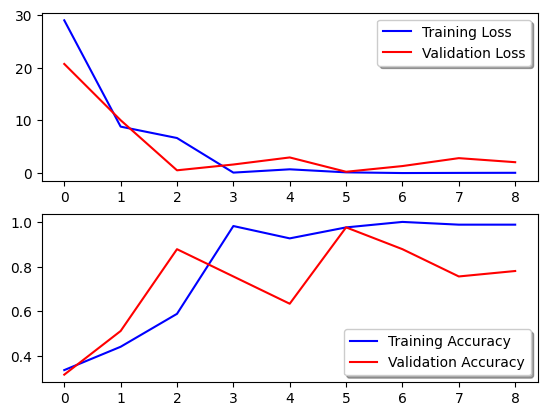

In [74]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [75]:
evaluation = model.evaluate(X_test, y_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

2/2 [==============================] - 0s 33ms/step - loss: 0.2418 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756
Test Accuracy : 97.56%


2/2 [==============================] - 0s 35ms/step


<Axes: >

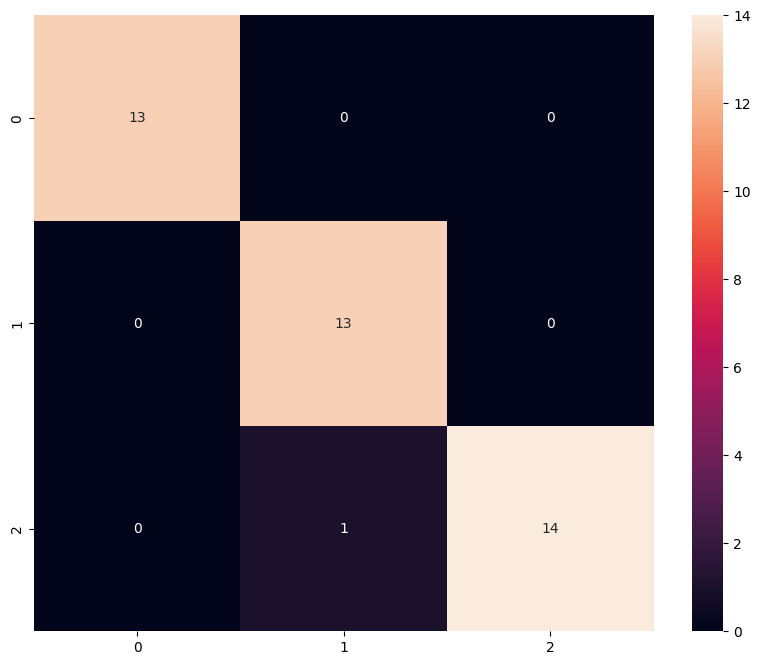

In [76]:
# Predict the values from the testing dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

In [77]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.93      1.00      0.96        13
           2       1.00      0.93      0.97        15

    accuracy                           0.98        41
   macro avg       0.98      0.98      0.98        41
weighted avg       0.98      0.98      0.98        41



In [78]:
model.save('yamnet_model.h5')

/home/hassan/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


: 

In [6]:
model = tf.keras.models.load_model('yamnet_model.h5')

NameError: name 'model' is not defined